In [1]:
# L'exécution de cette cellule démarre l'application Spark

Starting Spark application


ID,YARN Application ID,Kind,State,Spark UI,Driver log,User,Current session?
0,application_1680809092392_0001,pyspark,idle,Link,Link,None,✔


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

SparkSession available as 'spark'.


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

<u>Affichage des informations sur la session en cours et liens vers Spark UI</u> :

In [2]:
%%info

ID,YARN Application ID,Kind,State,Spark UI,Driver log,User,Current session?
0,application_1680809092392_0001,pyspark,idle,Link,Link,None,✔


### 4.10.2 Installation des packages

Les packages nécessaires ont été installé via l'étape de **bootstrap** à l'instanciation du serveur.

### 4.10.3 Import des librairies

In [3]:
import pandas as pd
import numpy as np
import io
import os
import tensorflow as tf
from PIL import Image
import matplotlib.pyplot as plt

from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2, preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras import Model

from pyspark.ml.feature import VectorAssembler, StandardScaler, PCA
from pyspark.ml.functions import array_to_vector
from pyspark.ml.functions import vector_to_array
from pyspark.sql.functions import col, pandas_udf, PandasUDFType, element_at, split
from pyspark.sql.functions import count

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

### 4.10.4 Définition des PATH pour charger les images et enregistrer les résultats

Nous accédons directement à nos **données sur S3** comme si elles étaient **stockées localement**.

In [4]:
PATH = 's3://p8-ms'
PATH_Data = PATH+'/Test'
PATH_Result = PATH+'/Results'
print('PATH:        '+\
      PATH+'\nPATH_Data:   '+\
      PATH_Data+'\nPATH_Result: '+PATH_Result)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

PATH:        s3://p8-ms
PATH_Data:   s3://p8-ms/Test
PATH_Result: s3://p8-ms/Results

### 4.10.5 Traitement des données

#### 4.10.5.1 Chargement des données

In [5]:
images = spark.read.format("binaryFile") \
  .option("pathGlobFilter", "*.jpg") \
  .option("recursiveFileLookup", "true") \
  .load(PATH_Data)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [6]:
images.show(5)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+-------------------+------+--------------------+
|                path|   modificationTime|length|             content|
+--------------------+-------------------+------+--------------------+
|s3://p8-ms/Test/P...|2023-04-04 09:03:12|  6574|[FF D8 FF E0 00 1...|
|s3://p8-ms/Test/P...|2023-04-04 09:03:09|  6573|[FF D8 FF E0 00 1...|
|s3://p8-ms/Test/P...|2023-04-04 09:03:11|  6573|[FF D8 FF E0 00 1...|
|s3://p8-ms/Test/P...|2023-04-04 09:02:57|  6572|[FF D8 FF E0 00 1...|
|s3://p8-ms/Test/P...|2023-04-04 09:03:06|  6572|[FF D8 FF E0 00 1...|
+--------------------+-------------------+------+--------------------+
only showing top 5 rows

<u>Je ne conserve que le **path** de l'image et j'ajoute <br />
    une colonne contenant les **labels** de chaque image</u> :

In [7]:
images = images.withColumn('label', element_at(split(images['path'], '/'),-2))
print(images.printSchema())
print(images.select('path','label').show(5,False))

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

root
 |-- path: string (nullable = true)
 |-- modificationTime: timestamp (nullable = true)
 |-- length: long (nullable = true)
 |-- content: binary (nullable = true)
 |-- label: string (nullable = true)

None
+-------------------------------------+---------+
|path                                 |label    |
+-------------------------------------+---------+
|s3://p8-ms/Test/Pineapple/99_100.jpg |Pineapple|
|s3://p8-ms/Test/Pineapple/289_100.jpg|Pineapple|
|s3://p8-ms/Test/Pineapple/326_100.jpg|Pineapple|
|s3://p8-ms/Test/Pineapple/143_100.jpg|Pineapple|
|s3://p8-ms/Test/Pineapple/243_100.jpg|Pineapple|
+-------------------------------------+---------+
only showing top 5 rows

None

#### 4.10.5.2 Préparation du modèle

In [8]:
model = MobileNetV2(weights='imagenet',
                    include_top=True,
                    input_shape=(224, 224, 3))

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

14536120/14536120 [==============================] - 1s 0us/step

In [9]:
new_model = Model(inputs=model.input,
                  outputs=model.layers[-2].output)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [10]:
new_model.summary()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                                             

#### traitement de diffusion des poids du modèle Tensorflow sur les clusters (broadcast des “weights” du modèle)

In [11]:
brodcast_weights = sc.broadcast(new_model.get_weights())

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [12]:
def model_fn():
    """
    Returns a MobileNetV2 model with top layer removed 
    and broadcasted pretrained weights.
    """
    model = MobileNetV2(weights='imagenet',
                        include_top=True,
                        input_shape=(224, 224, 3))
    for layer in model.layers:
        layer.trainable = False
    new_model = Model(inputs=model.input,
                  outputs=model.layers[-2].output)
    new_model.set_weights(brodcast_weights.value)
    return new_model

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

#### 4.10.5.3 Définition du processus de chargement des images <br/> et application de leur featurisation à travers l'utilisation de pandas UDF

In [13]:
def preprocess(content):
    """
    Preprocesses raw image bytes for prediction.
    """
    img = Image.open(io.BytesIO(content)).resize([224, 224])
    arr = img_to_array(img)
    return preprocess_input(arr)

def featurize_series(model, content_series):
    """
    Featurize a pd.Series of raw images using the input model.
    :return: a pd.Series of image features
    """
    input = np.stack(content_series.map(preprocess))
    preds = model.predict(input)
    # For some layers, output features will be multi-dimensional tensors.
    # We flatten the feature tensors to vectors for easier storage in Spark DataFrames.
    output = [p.flatten() for p in preds]
    return pd.Series(output)

@pandas_udf('array<float>', PandasUDFType.SCALAR_ITER)
def featurize_udf(content_series_iter):
    '''
    This method is a Scalar Iterator pandas UDF wrapping our featurization function.
    The decorator specifies that this returns a Spark DataFrame column of type ArrayType(FloatType).

    :param content_series_iter: This argument is an iterator over batches of data, where each batch
                              is a pandas Series of image data.
    '''
    # With Scalar Iterator pandas UDFs, we can load the model once and then re-use it
    # for multiple data batches.  This amortizes the overhead of loading big models.
    model = model_fn()
    for content_series in content_series_iter:
        yield featurize_series(model, content_series)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

/mnt/yarn/usercache/livy/appcache/application_1680809092392_0001/container_1680809092392_0001_01_000001/pyspark.zip/pyspark/sql/pandas/functions.py:398: UserWarning: In Python 3.6+ and Spark 3.0+, it is preferred to specify type hints for pandas UDF instead of specifying pandas UDF type which will be deprecated in the future releases. See SPARK-28264 for more details.

#### 4.10.5.4 Exécutions des actions d'extractions de features

In [14]:
# spark.conf.set("spark.sql.execution.arrow.maxRecordsPerBatch", "1024")

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [15]:
features_df = images.repartition(24).select(col("path"),
                                            col("label"),
                                            featurize_udf("content").alias("features")
                                           )

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [16]:
print(PATH_Result)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

s3://p8-ms/Results

In [17]:
features_df.printSchema()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

root
 |-- path: string (nullable = true)
 |-- label: string (nullable = true)
 |-- features: array (nullable = true)
 |    |-- element: float (containsNull = true)

In [18]:
features_df.show(5)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+--------------+--------------------+
|                path|         label|            features|
+--------------------+--------------+--------------------+
|s3://p8-ms/Test/P...|     Pineapple|[0.0, 3.632566, 0...|
|s3://p8-ms/Test/P...|     Pineapple|[0.0, 4.1071906, ...|
|s3://p8-ms/Test/P...|     Pineapple|[0.0, 3.6676247, ...|
|s3://p8-ms/Test/A...|Apple Golden 1|[0.0, 0.053870715...|
|s3://p8-ms/Test/P...|     Pineapple|[0.0039413804, 2....|
+--------------------+--------------+--------------------+
only showing top 5 rows

In [19]:
print(features_df.count())

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

1132

In [20]:
unique_labels = features_df.select("label").distinct().rdd.flatMap(lambda x: x).collect()
print(unique_labels)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

['Orange', 'Pineapple', 'Apple Golden 1', 'Kaki', 'Banana', 'Lemon', 'Corn']

In [21]:
counts = features_df.groupBy("label").agg(count("*").alias("count"))
counts.show()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------+-----+
|         label|count|
+--------------+-----+
|        Orange|  160|
|     Pineapple|  166|
|Apple Golden 1|  160|
|          Kaki|  166|
|        Banana|  166|
|         Lemon|  164|
|          Corn|  150|
+--------------+-----+

### ACP Sprak

In [22]:
type(features_df)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

<class 'pyspark.sql.dataframe.DataFrame'>

#### Vectorisation des features

In [23]:
# Apply the 'array_to_vector' function to the 'features_vectorized' column
features_df = features_df.withColumn("features_vectorized", array_to_vector("features"))

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [24]:
features_df.show(6)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+--------------+--------------------+--------------------+
|                path|         label|            features| features_vectorized|
+--------------------+--------------+--------------------+--------------------+
|s3://p8-ms/Test/P...|     Pineapple|[0.0, 3.632566, 0...|[0.0,3.6325659751...|
|s3://p8-ms/Test/P...|     Pineapple|[0.0, 4.1071906, ...|[0.0,4.1071906089...|
|s3://p8-ms/Test/P...|     Pineapple|[0.0, 3.6676247, ...|[0.0,3.6676247119...|
|s3://p8-ms/Test/A...|Apple Golden 1|[0.0, 0.053870715...|[0.0,0.0538707152...|
|s3://p8-ms/Test/P...|     Pineapple|[0.0039413804, 2....|[0.00394138041883...|
|s3://p8-ms/Test/P...|     Pineapple|[0.0, 4.1936307, ...|[0.0,4.1936306953...|
+--------------------+--------------+--------------------+--------------------+
only showing top 6 rows

#### Normalisation des features

In [25]:
scaler = StandardScaler(
    inputCol = 'features_vectorized', 
    outputCol = 'scaledFeatures',
    withMean = True,
    withStd = True
).fit(features_df)

# when we transform the dataframe, the old
# feature will still remain in it
df_scaled = scaler.transform(features_df)
df_scaled.show(6)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+--------------+--------------------+--------------------+--------------------+
|                path|         label|            features| features_vectorized|      scaledFeatures|
+--------------------+--------------+--------------------+--------------------+--------------------+
|s3://p8-ms/Test/P...|     Pineapple|[0.0, 3.632566, 0...|[0.0,3.6325659751...|[-0.7006761898096...|
|s3://p8-ms/Test/P...|     Pineapple|[0.0, 4.1071906, ...|[0.0,4.1071906089...|[-0.7006761898096...|
|s3://p8-ms/Test/P...|     Pineapple|[0.0, 3.6676247, ...|[0.0,3.6676247119...|[-0.7006761898096...|
|s3://p8-ms/Test/A...|Apple Golden 1|[0.0, 0.053870715...|[0.0,0.0538707152...|[-0.7006761898096...|
|s3://p8-ms/Test/P...|     Pineapple|[0.0039413804, 2....|[0.00394138041883...|[-0.6940887988535...|
|s3://p8-ms/Test/P...|     Pineapple|[0.0, 4.1936307, ...|[0.0,4.1936306953...|[-0.7006761898096...|
+--------------------+--------------+--------------------+--------------------+------------

#### Application de l'ACP

In [26]:
n_components = 100
pca = PCA(
    k = n_components, 
    inputCol = 'scaledFeatures', 
    outputCol = 'pcaFeatures'
).fit(df_scaled)

df_pca = pca.transform(df_scaled)
df_pca.show(6)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+--------------+--------------------+--------------------+--------------------+--------------------+
|                path|         label|            features| features_vectorized|      scaledFeatures|         pcaFeatures|
+--------------------+--------------+--------------------+--------------------+--------------------+--------------------+
|s3://p8-ms/Test/P...|     Pineapple|[0.0, 3.632566, 0...|[0.0,3.6325659751...|[-0.7006761898096...|[4.24952868426703...|
|s3://p8-ms/Test/P...|     Pineapple|[0.0, 4.1071906, ...|[0.0,4.1071906089...|[-0.7006761898096...|[4.78663711046702...|
|s3://p8-ms/Test/P...|     Pineapple|[0.0, 3.6676247, ...|[0.0,3.6676247119...|[-0.7006761898096...|[3.92177294440557...|
|s3://p8-ms/Test/A...|Apple Golden 1|[0.0, 0.053870715...|[0.0,0.0538707152...|[-0.7006761898096...|[7.16397370645045...|
|s3://p8-ms/Test/P...|     Pineapple|[0.0039413804, 2....|[0.00394138041883...|[-0.6940887988535...|[6.37464657896214...|
|s3://p8-ms/Test/P...|  

In [27]:
print('Variance expliquee:', pca.explainedVariance.sum())

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Variance expliquee: 0.906408857244218

In [28]:
# On ne conserve que la colonne pcaFeatures
df_pca= df_pca.select('path', 'label', 'pcaFeatures')
df_pca.show(5)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+--------------+--------------------+
|                path|         label|         pcaFeatures|
+--------------------+--------------+--------------------+
|s3://p8-ms/Test/P...|     Pineapple|[4.24952868426703...|
|s3://p8-ms/Test/P...|     Pineapple|[4.78663711046702...|
|s3://p8-ms/Test/P...|     Pineapple|[3.92177294440557...|
|s3://p8-ms/Test/A...|Apple Golden 1|[7.16397370645045...|
|s3://p8-ms/Test/P...|     Pineapple|[6.37464657896214...|
+--------------------+--------------+--------------------+
only showing top 5 rows

#### Affichage en 2 dimensions

In [29]:
print('Variance expliquee pour les 2 premieres dimensions', pca.explainedVariance[:2])

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Variance expliquee pour les 2 premieres dimensions [0.13908343 0.10581983]

In [30]:
# Somme de la variance expliquée pour les 2 premières dimensions
sum_explained_variance = sum(pca.explainedVariance[:2])
print("Somme de la variance expliquee pour les 2 premieres dimensions : ", sum_explained_variance)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Somme de la variance expliquee pour les 2 premieres dimensions :  0.2449032623755963

In [31]:
X_pca = df_pca.rdd.map(lambda row: row.pcaFeatures).collect()
X_pca = np.array(X_pca)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [32]:
y = df_pca.rdd.map(lambda row: row.label).collect()
y = np.array(y)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [33]:
# change default style figure and font size
plt.style.use('fivethirtyeight')
plt.rcParams['figure.figsize'] = 10, 8
plt.rcParams['font.size'] = 12


def plot_pca(X_pca, y):
    """a scatter plot of the 2-dimensional"""
    markers = 's', 'x', 'o', '+', '1', '|', 'h'
    colors = list(plt.rcParams['axes.prop_cycle'])
    target = np.unique(y)
    for idx, (t, m) in enumerate(zip(target, markers)):
        subset = X_pca[y == t]
        plt.scatter(subset[:, 0], subset[:, 1], s = 20,
#                    c = colors[idx]['color'], label = t, marker = m
                   )

    plt.xlabel('PC 1')
    plt.ylabel('PC 2')
    plt.legend(loc = 'upper left')
    plt.tight_layout()
    plt.show()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

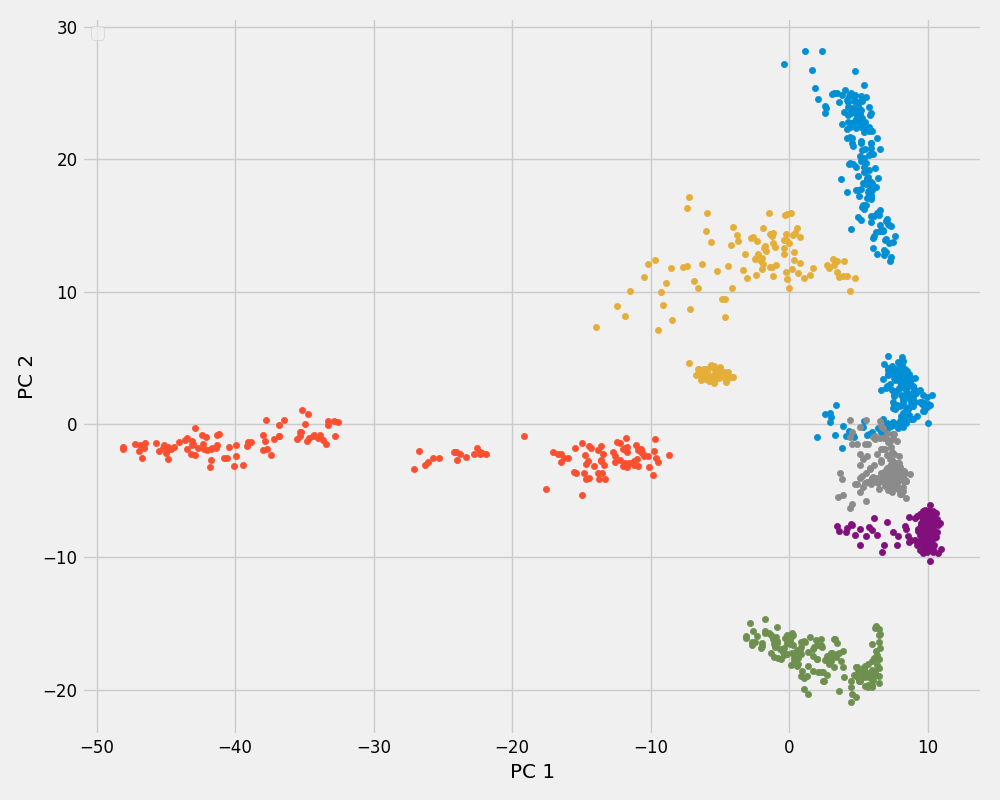

In [34]:
plot_pca(X_pca, y)
%matplot plt

In [35]:
df_pca.printSchema()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

root
 |-- path: string (nullable = true)
 |-- label: string (nullable = true)
 |-- pcaFeatures: vector (nullable = true)

In [36]:
# vector to array
df_pca = df_pca.withColumn("pcaFeatures", vector_to_array("pcaFeatures"))
df_pca = df_pca.select('path', 'label', 'pcaFeatures')
df_pca.show(5)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+--------------+--------------------+
|                path|         label|         pcaFeatures|
+--------------------+--------------+--------------------+
|s3://p8-ms/Test/P...|     Pineapple|[4.24952868426703...|
|s3://p8-ms/Test/P...|     Pineapple|[4.78663711046702...|
|s3://p8-ms/Test/P...|     Pineapple|[3.92177294440557...|
|s3://p8-ms/Test/A...|Apple Golden 1|[7.16397370645045...|
|s3://p8-ms/Test/P...|     Pineapple|[6.37464657896214...|
+--------------------+--------------+--------------------+
only showing top 5 rows

In [37]:
df_pca.printSchema()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

root
 |-- path: string (nullable = true)
 |-- label: string (nullable = true)
 |-- pcaFeatures: array (nullable = false)
 |    |-- element: double (containsNull = false)

In [38]:
print(PATH_Result)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

s3://p8-ms/Results

### Enregistrement des Resultats

In [39]:
# au format parquet
df_pca.write.mode("overwrite").parquet(PATH_Result)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [40]:
# df_pca = spark.read.parquet(PATH_Result)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [41]:
df = df_pca.select("*").toPandas()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [42]:
df.head()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

                                         path  ...                                        pcaFeatures
0       s3://p8-ms/Test/Pineapple/209_100.jpg  ...  [4.249528684267031, 24.29155204063384, -16.101...
1        s3://p8-ms/Test/Pineapple/24_100.jpg  ...  [4.786637110467027, 23.88517594245971, -15.595...
2       s3://p8-ms/Test/Pineapple/197_100.jpg  ...  [3.9217729444055713, 23.539003012275177, -16.1...
3  s3://p8-ms/Test/Apple Golden 1/130_100.jpg  ...  [7.163973706450456, 4.234909962497389, 10.7138...
4      s3://p8-ms/Test/Pineapple/r_81_100.jpg  ...  [6.374646578962141, 18.568245346159973, -11.51...

[5 rows x 3 columns]

In [43]:
# au format csv
df.to_csv("{}/results.csv".format(PATH_Result), index=False)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [44]:
# Lecture du fichier csv
df = pd.read_csv("{}/results.csv".format(PATH_Result))
df.head()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

                                         path  ...                                        pcaFeatures
0       s3://p8-ms/Test/Pineapple/209_100.jpg  ...  [4.249528684267031, 24.29155204063384, -16.101...
1        s3://p8-ms/Test/Pineapple/24_100.jpg  ...  [4.786637110467027, 23.88517594245971, -15.595...
2       s3://p8-ms/Test/Pineapple/197_100.jpg  ...  [3.9217729444055713, 23.539003012275177, -16.1...
3  s3://p8-ms/Test/Apple Golden 1/130_100.jpg  ...  [7.163973706450456, 4.234909962497389, 10.7138...
4      s3://p8-ms/Test/Pineapple/r_81_100.jpg  ...  [6.374646578962141, 18.568245346159973, -11.51...

[5 rows x 3 columns]